In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/23628
# 标题：python搭建_简单_交易系统

#import ashare
#from ashare import *
#from django.shortcuts import render
# Create your views here.

import os
import json
import datetime
import random
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import math
import ssdata
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math
import ssdata
import matplotlib.pyplot as plt
import time
import lhptdata as lh

print('ok')


# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import math
import ssdata  #不能用了
import matplotlib.pyplot as plt

#import jqdatasdk as jq
from jqdatasdk import *
auth('','')

ok
auth success


In [7]:
###############################################################################
#                           Define framework classes                          #
###############################################################################

class account_class:
    def __init__(self, start_date, end_date, capital_base, freq, benchmark,
                 universe, tax=0.001, commission=0.00025, slippage=0.01):
        """
        start_date: the start date of back test
        end_date: the end date of back test
        capital_base: initial fund to perform back test
        freq: back test frequencies, measured in days, eg. 1 for daily and 7
            for weekly
        tax: tax rate
        commission: commission rate
        slippage: slippage
        """
        self.start_date = start_date
        self.end_date = end_date
        self.capital_base = capital_base
        self.freq = freq
        self.benchmark = benchmark
        self.universe = universe
        self.tax = tax
        self.commission = commission
        self.slippage = slippage

        self.ini_dic = None
        self.benchmark_data = None
        self.trade_days = None
        self.order_days = None
        self.today_capital = None
        self.ret = None    #计算 return  收益率
        self.history_max = None
        self.drawdown_start = None
        self.drawdown_end = None
        self.capital = None
        self.cash = None
        self.today = None

    def setup(self):
        self.ini_dic = {}
        self.benchmark_data = pd.DataFrame()
        self.ret = pd.DataFrame()  #收益率为 df
        self.history_max = 0
        self.capital = []
        self.cash = capital_base
        
        #调用函数
        self.set_dic()    #调用不用写 self
        self.set_days()   #调用不用写 self


        
    def set_dic(self):  #定义需要写 self
        
        # 根据股票池，初始化【股票字典】key为股票代码，value为data，的开盘价

        for stock in self.universe:
            #df = get_price("000001.XSHE")
            #print(df)
            
            # print(data) 日期为索引，开盘价，同一个股票代码为2列的【dataframe格式】
            # 
            try:
                '''
                data = ssdata.get_data(secid=stock,
                                       start_date=self.start_date,
                                       end_date=self.end_date,
                                       field='open').sort_index()
                
                df = get_price('000001.XSHE', start_date='2015-01-01', end_date='2015-01-31 23:00:00', 
                frequency='minute', fields=['open', 'close']) 
                # 获得000001.XSHG的2015年01月的分钟数据, 只获取open+close字段
                
                ''' 
                data123 = get_price(stock,
                                  start_date=self.start_date,
                                  end_date=self.end_date,
                                  frequency='daily',
                                  fields=['open'],
                                  ).sort_index()
                #print('data123', data123)
                #print(type(data123))
                self.ini_dic[stock] = data123
               
                
            except Exception:
                self.universe.remove(stock)
                print("Stock ", stock, " data unavailable.")

        try:
            
            '''
            data = ssdata.get_data(secid=self.benchmark,
                                   start_date=self.start_date,
                                   end_date=self.end_date,
                                   field='open').sort_index()
            '''
            data1 = get_price(self.benchmark,
                                  start_date=self.start_date,
                                  end_date=self.end_date,
                                  frequency='daily',
                                  fields=['open'],
                                  )['open'].sort_index()
            
            
            print(type(data1))
            #print('data1:',data1)
            #self.benchmark_data = self.benchmark_data.append(data1)
            self.benchmark_data = data1
            
        except Exception:
            
            print("Benchmark ", self.benchmark, " data unavailable.")
        
       

    def set_days(self):
        """
        Set up the ini_dic, benchmark_data, trade_days and order_days.
        
        # 初始化2个日期 列表，交易日 和 下单日/调仓日
        # self.trade_days=[a for i in self.ini_dic[self.universe[0]].index a=i.strftime('%Y-%m-%d')]
        list121=[]
        for i in self.ini_dic[self.universe[0]].index:
            print(i)
            a=i.strftime('%Y-%m-%d')
            print(a)
            list121.append(a)
        self.trade_days=list121
        """    
        self.trade_days = self.ini_dic[self.universe[0]].index
        self.order_days = self.get_order_days()

    def get_order_days(self):
        # 根据 【交易日】和【调仓频率】，计算出【下单日/调仓日】
        """
        Return the list of order days based on frequency.
        """
        tdays = list(self.trade_days)
        odays = []
        for i in range(len(tdays)):
            if i % self.freq == 0:
                odays.append(tdays[i])
        return odays



In [8]:
###############################################################################
#                          Define framework functions                         #
###############################################################################

def order_to(target):#传入保存 股票数量的序列
    global h_amount
    global account  #声明 全局变量
    trade_days = account.trade_days
    order_days = account.order_days
    tax = account.tax
    commission = account.commission
    ini_dic = account.ini_dic  #获取价格
    #today_capital = account.today_capital 计算drawdown
    slippage = account.slippage
    date = account.today #访问全局变量，调用时，今天的日期
    if date in order_days: #检测当天 是否 在 下单日 列表里
        
        print('下单函数中，输出调仓日期和 选中的股票',date.strftime('%Y-%m-%d'), list(target.index))
        t_amount = pd.DataFrame({'tamount': [0]}, index=list(target.index))

        # Sell stocks in holding but not in target
        for stock in list(h_amount.index):
            if stock not in list(target.index):
                stock_data = ini_dic[stock].loc[date.strftime('%Y-%m-%d')]# 获取 日期
                price = stock_data['open']  #获取开盘价
                #计算资金=数量*开盘价
                account.cash += h_amount.loc[stock, 'hamount'] * \
                                (price - slippage) * (1 - tax - commission)
                print('order: ', stock, 'amount ',
                      int(0 - h_amount.loc[stock, 'hamount']))
                h_amount=h_amount.drop(stock) #bug

        # Deal with stocks /in target
        for stock in list(target.index):
            stock_data = ini_dic[stock].loc[date.strftime('%Y-%m-%d')]
            price = stock_data['open'] #获取股票的开盘价

            # Buy stocks in target /but not in holding
            if stock not in list(h_amount.index):
                h_amount = h_amount.append(pd.DataFrame({'hamount': [0],
                                                         'price': [0],
                                                         'value': [0],
                                                         'percent': [0]},
                                                        index=[stock]))
            # 下单 股票的数量
            t_amount.loc[stock, 'tamount'] = math.floor(target[stock] / 100) * 100

            # If hoding > target, sell
            if h_amount.loc[stock, 'hamount'] - t_amount.loc[stock, 'tamount'] \
                    > 0:
                account.cash += (h_amount.loc[stock, 'hamount'] -
                                 t_amount.loc[stock, 'tamount']) \
                                * (price - slippage) * (1 - tax - commission)

            # If hoding < target, buy
            if h_amount.loc[stock, 'hamount'] - t_amount.loc[stock, 'tamount'] \
                    < 0:
                # Attention: buy hand by hand in case cash becomes negative
                for number in range(int(t_amount.loc[stock, 'tamount'] / 100),
                                    0, -1):
                    if account.cash - (number * 100 -
                                       h_amount.loc[stock, 'hamount']) * \
                            (price + slippage) * (1 + commission) < 0:
                        continue
                    else:
                        account.cash -= (number * 100 -
                                         h_amount.loc[stock, 'hamount']) * \
                                        (price + slippage) * (1 + commission)
                        t_amount.loc[stock, 'tamount'] = number * 100
                        break

            if h_amount.loc[stock, 'hamount'] - t_amount.loc[stock, 'tamount'] \
                    != 0:
                print('order: ', stock, 'amount ',
                      int(t_amount.loc[stock, 'tamount'] -
                          h_amount.loc[stock, 'hamount']))

            h_amount.loc[stock, 'hamount'] = t_amount.loc[stock, 'tamount']
            h_amount.loc[stock, 'price'] = price
            h_amount.loc[stock, 'value'] = h_amount.loc[stock, 'price'] * \
                                           h_amount.loc[stock, 'hamount']

        h_amount['percent'] = h_amount['value'] / sum(h_amount['value'])
    
    # 把drawdown()独立成了函数
    # Output holding details
    h_amount.to_csv('position_details666.csv')


def order_pct_to(pct_target): # 传入参数  买入股票的 百分比
    global account # 声明全局变量
    date = account.today
    ini_dic = account.ini_dic  #获取 股票的价格
    today_capital = account.today_capital #资金
    target = pd.Series()  #保存 股票数量的序列

    for stock in list(pct_target.index):
        stock_data = ini_dic[stock].loc[date.strftime('%Y-%m-%d')]
        price = stock_data['open'] #获取股票的开盘价，价格
        #计算股票的数量 = 资金/价格  #资金=今日资金量*百分比
        target[stock] = (pct_target[stock] * today_capital) / price

    order_to(target)# 传入目标股票数量


def result_display(): # 结果 展示
    global account
    """
    Display results, 
    including the return curve and a table 
    showing returns drawdown and drawdown intervals.
    """
    # account.ret.to_csv('return_details.csv')
    # strategy annual return
    Ra = (1 + (account.ret.iloc[-1].rev)) ** \
         (250 / len(list(account.trade_days))) - 1
    print('account.ret:',account.ret)

    results = pd.DataFrame({'benchmark return':
                                '%.2f%%' % (account.ret.iloc[-1].benchmark * 100),
                            'Strategy return':
                                '%.2f%%' % (account.ret.iloc[-1].rev * 100),
                            'Strategy annual return':
                                '%.2f%%' % (Ra * 100),
                            'Max drawdown':
                                '%.2f%%' % (account.ret.iloc[-1].max_drawdown * 100),
                            'Max drawdown interval':
                                str(account.drawdown_start.strftime('%Y-%m-%d')
                                    + ' to '
                                    + account.drawdown_end.strftime('%Y-%m-%d'))},
                           index=[''])

    results.reindex(['benchmark return',
                     'Strategy return',
                     'Strategy annual return',
                     'Max drawdown',
                     'Max drawdown interval'], axis=1)
    print(results.transpose())
    return results
'''
    # plot the results
    account.ret['rev'].plot(color='royalblue', label='strategy return')
    account.ret['benchmark'].plot(color='black', label='benchmark return')
    x = np.array(list(account.ret.index))
    plt.fill_between(x, max(max(account.ret.rev), max(account.ret.benchmark)),
                     min(min(account.ret.rev), min(account.ret.benchmark)),
                     where=((x <= account.drawdown_end) &
                            (x >= account.drawdown_start)),
                     facecolor='lightsteelblue',
                     alpha=0.4)
    plt.legend()
    plt.show()

'''
###############################################################################
#                   Parameters and functions set up manually                  #
###############################################################################


def initialize(account):
    """
    This is a function that runs only once, before the backtest begins.
    """
    pass


def handle_data():
    #global account
    """
    This is a function that runs every backtest frequency.
    """
    w=1
    # 增加 选股函数，返回列表 ，赋值给list, 【不修改 account.universe】
    #股票池固定为 14支银行股，如果修改account.universe，（只有3支股票）再次运行还需要初始化，与h_amount.index （14支股票）不一致
    list = GrahamStockFilter()
    
    positions = pd.Series()# 股票/仓位/百分比的序列
    for stock in list:
    #for stock in GrahamStockFilter(account):
        # positions[stock] = 0.5
        positions[stock] = 1 / len(list) *w    # 得到 股票所占仓位的平均百分比
        print(positions[stock])

    #for stock in account.universe:
        #positions[stock] = 0.5
    order_pct_to(positions)


In [16]:
#【计算 最大回撤的函数】
def drawdown():  # 必须在【每个交易日】计算最大回撤,【声明/访问/全局变量】或者【通过参数，传入date】
    global account
    date = account.today
    print('drawdown_date', date)
    date = account.today
    today_capital = account.today_capital #获取当日的资金
    trade_days = account.trade_days      # 必须在每个交易日 计算最大回撤

    account.capital.append(today_capital) #将【今天的资金量】 累加到account.capital中
    #计算公式 前n-1天资金的最大值 减 第n天的资金 除以 第n天的资金
    try:
        drawdown = (max(account.capital[:-1]) - account.capital[-1]) / \
                   max(account.capital[:-1])
    except Exception:
        drawdown = 0

    if drawdown > account.history_max:#大于历史最高，保存为最大，和日期
        account.drawdown_start = \
            trade_days[account.capital.index(max(account.capital[:-1]))]
        account.drawdown_end = \
            trade_days[account.capital.index(account.capital[-1])]

        account.history_max = drawdown #最大值保存


#【计算收益率结果】
def ret():  # 必须在【每个交易日】【计算收益率结果】,【声明/访问/全局变量】或者【通过参数，传入date】
    global account
    benchmark = account.benchmark # 列索引
    #print(code1)
    
    #每个交易日计算 收益率的df，并累加到df
    #print(account.benchmark_data)
    date = account.today  #当天的日期
    trade_days = account.trade_days
    
    print('当天的日期为：',date)
    #print('当天的日期为：',date.strftime('%Y-%m-%d'))
    
    account.ret = account.ret.append(
        pd.DataFrame(
          {
           'rev': (account.capital[-1] - account.capital[0]) / account.capital[0],
           'max_drawdown': account.history_max,
           'benchmark':
             (account.benchmark_data.loc[date, '000001.XSHE'] -
              account.benchmark_data.loc[trade_days[0],  '000001.XSHE']) /
              account.benchmark_data.loc[trade_days[0],  '000001.XSHE']},
          index=[date]
        )
    )
    print('account.capital每天的资金量列表:',account.capital)

###############################################################################
#                               Backtest begins                               #
###############################################################################
#
'''
#print("程序开始")
start_date = '2015-01-01'
end_date = '2016-01-01'

freq = 1
benchmark = ['000001.XSHE']
# universe = ['600036.XSHG', '601166.XSHG']
universe = ['000001.XSHE', '002142.XSHE', '600000.XSHG', '600015.XSHG', '600016.XSHG',
            '600036.XSHG', '601009.XSHG', '601166.XSHG', '601169.XSHG', '601328.XSHG', '601398.XSHG',
            '601939.XSHG', '601988.XSHG', '601998.XSHG']
account = account_class(start_date=start_date, end_date=end_date,
                  capital_base=capital_base, freq=freq,
                  benchmark=benchmark, universe=universe)
account.setup()  # 继续初始化
initialize(account)  # pass

#初始化，h_amount
h_amount = pd.DataFrame({'hamount': [0],
                         'price': [0],
                         'value': [0],
                         'percent': [0]}, index=universe)
#初始化，h_amount的index

print('首次初始化完毕')
'''

# 初始化 函数，只执行一次。最初股票池的，获得的交易日，通过交易频率，得到调仓日，返回一个实例account 全局变量


def backtest1(start_date1, end_date1, freq1):
    global capital_base

    global account
    global h_amount

    # global freq
    universe = ['000001.XSHE', '002142.XSHE', '600000.XSHG', '600015.XSHG', '600016.XSHG',
                '600036.XSHG', '601009.XSHG', '601166.XSHG', '601169.XSHG', '601328.XSHG', '601398.XSHG',
                '601939.XSHG', '601988.XSHG', '601998.XSHG']

    benchmark = ['000001.XSHE']
    
    # account.start_date = start_date1
    # account.end_date = end_date1
    # account.capital_base=capital_base1
    
    #创建 对象
    account = account_class(start_date=start_date1, end_date=end_date1,
                            capital_base=capital_base, freq=freq1,
                            benchmark=benchmark, universe=universe)

    h_amount = pd.DataFrame({'hamount': [0],
                             'price': [0],
                             'value': [0],
                             'percent': [0]},
                            index=universe)
    # account.freq = freq1
    # account = account(start_date=start_date, end_date=end_date,
    # capital_base=capital_base)
    # freq=freq,benchmark=benchmark, universe=universe)
    account.setup()  # 根据 交易频率，初始化交易日
    initialize(account)  # pass
    print('初始化完毕')
    # return account
    # 在调仓日 进行回测
    # def backtest(account):
    # print(type(account), "开始回测") # 实例变量
    
    for date in account.trade_days:  # 按照 交易日，回测
        print('日期',date)
        # print('日期',date.strftime('%Y-%m-%d'))
        account.today = date  #.strftime('%Y-%m-%d')  # 更新当天的日期，将当天的日期 赋值给全局对象account
        # print(account.today)
        # test(account, h_amount)
        print('交易日')

        # 调仓日，初始化 持有仓位 df，计算当天的资金量
        account.today_capital = 0
        for stock in list(h_amount.index):

            stock_data = account.ini_dic[stock].loc[date] #.strftime('%Y-%m-%d')

            price = stock_data['open']#得到开盘价，价格

            account.today_capital += price * h_amount.loc[stock, 'hamount']

        account.today_capital += account.cash
        # 调仓日，初始化 持有仓位 df，计算当天的资金量，计算完毕

        # 【交易日，当天 初始化完毕】
        print('计算drawdown')
        drawdown()  # 遍历所有【交易日】，才能 计算最大回测
        
        print('计算收益率')
        ret()       # 在【每个交易日】计算收益率结果
        
        if date in account.order_days:  # 只在下单日，调仓日，选股，下单
            
            handle_data()  # 选股，调仓，
            
          # print(h_amount)  # 输出仓位
        
        print('ok')
        
        try:
            pass
            # print(h_amount)
            # result_display()
        except:

            
            pass
            # handle_data(account)  # 交易日，当天，调用 处理函数


#backtest('2015-01-01', '2016-01-01', 20)
#result_display()
#print(h_amount)
#del account
#del h_amount

In [17]:
# 银行翻倍 选股函数
def GrahamStockFilter():
    today = account.today
    ########################################################################
    # 14
    # stock_list = ['000001.SZ', '002142.SZ', '600000.SH', '600015.SH', '600016.SH', '600036.SH', '601009.SH',
    # '601166.SH', '601169.SH', '601328.SH', '601398.SH', '601939.SH', '601988.SH', '601998.SH']
    # 16
    # stock_list=['000001.SZ', '002142.SZ', '600000.SH', '600015.SH', '600016.SH', '600036.SH', '601009.SH', '601166.SH', '601169.SH', '601288.SH', '601328.SH', '601398.SH', '601818.SH', '601939.SH', '601988.SH', '601998.SH']
    ########################################################################

    ''''''
    stock_list = ['000001.XSHE', '002142.XSHE', '600000.XSHG', '600015.XSHG', '600016.XSHG',
                  '600036.XSHG', '601009.XSHG', '601166.XSHG', '601169.XSHG', '601328.XSHG', '601398.XSHG',
                  '601939.XSHG', '601988.XSHG', '601998.XSHG']
    df12 = pd.DataFrame()
    # df2 = pd.DataFrame([[5, 6], [7, 8]], columns=list('AB'))
    for stock in stock_list:
        # df2 = pd.DataFrame([[5, 6], [7, 8]], columns=list('AB'))
        # df1.append(df2)
        q = query(
            valuation.code,  # valuation.symbol,

            valuation.pb_ratio,  # valuation.pb,
            valuation.capitalization,  # 总股本
            valuation.market_cap,  # 总市值

            indicator.eps,  # income.basic_eps,
            indicator.roe,  # profit_one_season.roe,

            indicator.operating_profit,  # income_one_season.profit_from_operations,
            indicator.inc_operation_profit_annual  # growth_one_season.opt_profit_growth_ratio

        ).filter(
            valuation.code == stock
        )
        df = get_fundamentals(q, today.strftime('%Y-%m-%d'))
        # 打印出总市值 2015q1
        # print(df['market_cap'][0])
        df12 = df12.append(df)
    # print(df12)

    df12 = df12.set_index(df12['code'])
    # 筛选ROE大于0的股票
    df12 = df12[df12['roe'] > 0]
    # 收盘价列表
    df12['close'] = list([float("nan")] * (len(df12.index)))
    # 有财务数据的股票列表
    true_list = list(df12.index)

    panel = get_price(true_list, start_date=today.strftime('%Y-%m-%d'),

                      end_date=today.strftime('%Y-%m-%d'), frequency='daily', fields=None, skip_paused=False,
                      fq='pre')
    df_close = panel['close']
    # 每股营业利润
    df12['pps'] = df12['operating_profit'] / df12['capitalization']

    # 将收盘价合并入之前的数据当中，方便之后筛选
    for stock in true_list:
        df12.loc[stock, 'close'] = df_close[stock].values[0]

    # 格氏成长公式
    df12['value'] = df12['pps'] * (27 + 2 * df12['inc_operation_profit_annual'] / 100)

    df12['outvalue_ratio'] = df12['value'] / df12['close']
    df12 = df12.sort_values("outvalue_ratio", ascending=False)
    df_value = df12  # [:30]

    # 小市值因子
    df_value = df_value.sort_values("market_cap", ascending=True)
    df_value = df_value[:10]

    df_value = df_value.sort_values("outvalue_ratio", ascending=False)
    df_value = df_value[:3]

    buylist_value = list(df_value['code'].values)

    # 翻倍期

    # import math
    df12['double_time'] = df12.apply(lambda row: round(math.log(2.0 * row['pb_ratio'], (1.0 + row['roe'] / 100)), 2),
                                     axis=1)
    df_double = df12.sort_values('double_time', ascending=True)
    df_double = df_double[:3]
    buylist_double = list(df_double['code'].values)

    # 取交集
    buylist = [v for v in buylist_value if v in buylist_double]
    # buylist=list(buylist_value)+list(buylist_double)
    # 如果交集为空，取银行翻倍股票
    if len(buylist) == 0:
        buylist = buylist_double
    # log.info(get_datetime().strftime('%Y-%m-%d')+'选股为'+ str(buylist)[1:-1])

    return buylist  # 修改样本量，返回 要买入的选股列表


# 格式选股 函数 GrahamStockFilter1【未用】
def GrahamStockFilter1(account):
    # date = get_datetime()
    today = account.today.strftime('%Y-%m-%d')
    # signal = MarketSignal(account)

    # 得到全A股去除ST和停牌股票的股票列表
    # stk = list(get_all_securities('stock', date).index)
    stk = list(get_all_securities(['stock']).index)

    ########################################################################

    # yesterday = get_last_datetime().strftime('%Y%m%d')
    q = query(valuation.code,

              # balance.total_equity,
              indicator.eps,  # income.basic_eps, #
              valuation.pb_ratio,  # valuation.pb,#
              valuation.market_cap,  #
              indicator.operating_profit,  # income_one_season.profit_from_operations, #
              valuation.capitalization,  #
              indicator.roe,  # profit_one_season.roe,  #
              indicator.inc_operation_profit_annual,  # growth_one_season.opt_profit_growth_ratio,#
              indicator.inc_net_profit_annual     # growth_one_season.net_profit_growth_ratio)\
              ).filter(valuation.code.in_(stk))  # .order_by(valuation.symbol)
    
    df1 = get_fundamentals(q, today)
    df1 = df1.set_index(df1['code'])

    # 筛选ROE大于0的股票
    df1 = df1[df1['roe'] > 0]
    # 筛选净利润同比增长率大于0的股票 inc_net_profit_annual growth_one_season.net_profit_growth_ratio)
    df1 = df1[df1['inc_net_profit_annual'] > 0]

    # 收盘价列表
    df1['close'] = list([float("nan")] * (len(df1.index)))

    # 有财务数据的股票列表
    true_list = list(df1.index)
    # 收盘价赋值
    panel = get_price(true_list, start_date=account.today.strftime('%Y-%m-%d'),

                      end_date=account.today.strftime('%Y-%m-%d'), frequency='daily', fields=None, skip_paused=False,
                      fq='pre')
    close_p = panel['close']

    # close_p = history(true_list, ['close'], 1, '1d',
    # skip_paused=False, fq='pre', is_panel=0)
    # 将收盘价合并入之前的数据当中，方便之后筛选
    for stock in true_list:
        try:
            df1.loc[stock, 'close'] = close_p[stock].values[0]
        except:
            # log.info(stock)
            # log.info(close_p[stock])
            df1.loc[stock, 'close'] = 10000000000
            
    # 每股营业利润
    df1['pps'] = df1['operating_profit'] / df1['capitalization']

    # 格氏成长公式
    df1['value'] = df1['pps'] * \
                   (27 + 2 * df1['inc_operation_profit_annual'] / 100)
    df1['outvalue_ratio'] = df1['value'] / df1['close']
    df1.dropna(inplace=True)
    
    df1 = df1.sort_values("outvalue_ratio", ascending=False)
    df1 = df1[:40]

    df1 = df1.sort_values("market_cap", ascending=True)[:20]

    buylist = list(df1['code'].values)
    

    return buylist  # 选出股票




In [18]:
capital_base = 1000000    #资金
start_date = '2015-01-01' #起始日期
end_date = '2016-01-01'   #终止日期
freq = 1 # 调仓频率

#backtest( start_date , end_date, freq)
#backtest
print('start')

backtest1('2015-01-01', '2016-01-01', 5)

#print(h_amount)
#call(account1)
#调用输出结果函数
#print(result_display(account)) #df转为字典的函数： df.to_dict，结果：字典作为元素 组成的列表
            print('end')



start
<class 'pandas.core.frame.DataFrame'>
初始化完毕
日期 2015-01-05 00:00:00
交易日
计算drawdown
drawdown_date 2015-01-05 00:00:00
计算收益率
当天的日期为： 2015-01-05 00:00:00
account.capital每天的资金量列表: [1000000.0]
1.0
下单函数中，输出调仓日期和 选中的股票 2015-01-05 ['600000.XSHG']
order:  000001.XSHE amount  0
order:  002142.XSHE amount  0
order:  600015.XSHG amount  0
order:  600016.XSHG amount  0
order:  600036.XSHG amount  0
order:  601009.XSHG amount  0
order:  601166.XSHG amount  0
order:  601169.XSHG amount  0
order:  601328.XSHG amount  0
order:  601398.XSHG amount  0
order:  601939.XSHG amount  0
order:  601988.XSHG amount  0
order:  601998.XSHG amount  0
order:  600000.XSHG amount  102600
ok
日期 2015-01-06 00:00:00
交易日
计算drawdown
drawdown_date 2015-01-06 00:00:00
计算收益率
当天的日期为： 2015-01-06 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169]
ok
日期 2015-01-07 00:00:00
交易日
计算drawdown
drawdown_date 2015-01-07 00:00:00
计算收益率
当天的日期为： 2015-01-07 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.168999

1.0
下单函数中，输出调仓日期和 选中的股票 2015-02-09 ['600000.XSHG']
ok
日期 2015-02-10 00:00:00
交易日
计算drawdown
drawdown_date 2015-02-10 00:00:00
计算收益率
当天的日期为： 2015-02-10 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999]
ok
日期 2015-02-11 00:00:00
交易日
计算drawdown
drawdown_date 2015-02-11 00:00:00
计算收益率
当天的日期为： 2015-02-11 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.1

1.0
下单函数中，输出调仓日期和 选中的股票 2015-03-09 ['600000.XSHG']
ok
日期 2015-03-10 00:00:00
交易日
计算drawdown
drawdown_date 2015-03-10 00:00:00
计算收益率
当天的日期为： 2015-03-10 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999]
ok
日期 2015-03-11 00:00:00
交易日
计算drawdown
drawdown_date 2015-03-11 00:00:00
计算收益率
当天的日期为： 201

1.0
下单函数中，输出调仓日期和 选中的股票 2015-03-23 ['600000.XSHG']
ok
日期 2015-03-24 00:00:00
交易日
计算drawdown
drawdown_date 2015-03-24 00:00:00
计算收益率
当天的日期为： 2015-03-24 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1689999999, 920748.169, 954606.169, 978204.1689999998, 980256.169, 979230.1689999998,

0.5
0.5
下单函数中，输出调仓日期和 选中的股票 2015-04-07 ['600000.XSHG', '600015.XSHG']
order:  600000.XSHG amount  -500
order:  600015.XSHG amount  500
ok
日期 2015-04-08 00:00:00
交易日
计算drawdown
drawdown_date 2015-04-08 00:00:00
计算收益率
当天的日期为： 2015-04-08 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1

1.0
下单函数中，输出调仓日期和 选中的股票 2015-04-21 ['600000.XSHG']
ok
日期 2015-04-22 00:00:00
交易日
计算drawdown
drawdown_date 2015-04-22 00:00:00
计算收益率
当天的日期为： 2015-04-22 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1689999999, 920748.169, 954606.169, 978204.1689999998, 980256.169, 979230.1689999998,

0.3333333333333333
0.3333333333333333
0.3333333333333333
下单函数中，输出调仓日期和 选中的股票 2015-05-06 ['601939.XSHG', '601166.XSHG', '601328.XSHG']
order:  601169.XSHG amount  -179100
order:  601939.XSHG amount  72300
order:  601166.XSHG amount  24700
order:  601328.XSHG amount  69100
ok
日期 2015-05-07 00:00:00
交易日
计算drawdown
drawdown_date 2015-05-07 00:00:00
计算收益率
当天的日期为： 2015-05-07 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.168999999

0.3333333333333333
0.3333333333333333
0.3333333333333333
下单函数中，输出调仓日期和 选中的股票 2015-05-20 ['601939.XSHG', '601398.XSHG', '601328.XSHG']
order:  601166.XSHG amount  -24200
order:  601939.XSHG amount  -100
order:  601328.XSHG amount  69100
ok
日期 2015-05-21 00:00:00
交易日
计算drawdown
drawdown_date 2015-05-21 00:00:00
计算收益率
当天的日期为： 2015-05-21 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999

0.3333333333333333
0.3333333333333333
0.3333333333333333
下单函数中，输出调仓日期和 选中的股票 2015-05-27 ['601939.XSHG', '601398.XSHG', '601328.XSHG']
order:  601398.XSHG amount  -1000
order:  601328.XSHG amount  600
ok
日期 2015-05-28 00:00:00
交易日
计算drawdown
drawdown_date 2015-05-28 00:00:00
计算收益率
当天的日期为： 2015-05-28 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.16899

0.3333333333333333
0.3333333333333333
0.3333333333333333
下单函数中，输出调仓日期和 选中的股票 2015-06-03 ['601939.XSHG', '601398.XSHG', '601166.XSHG']
order:  601328.XSHG amount  -69700
order:  601939.XSHG amount  1600
order:  601398.XSHG amount  4500
order:  601166.XSHG amount  24700
ok
日期 2015-06-04 00:00:00
交易日
计算drawdown
drawdown_date 2015-06-04 00:00:00
计算收益率
当天的日期为： 2015-06-04 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 

0.3333333333333333
0.3333333333333333
0.3333333333333333
下单函数中，输出调仓日期和 选中的股票 2015-06-10 ['601398.XSHG', '601939.XSHG', '601166.XSHG']
order:  601398.XSHG amount  100
order:  601939.XSHG amount  -600
order:  601166.XSHG amount  -300
ok
日期 2015-06-11 00:00:00
交易日
计算drawdown
drawdown_date 2015-06-11 00:00:00
计算收益率
当天的日期为： 2015-06-11 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999,

1.0
下单函数中，输出调仓日期和 选中的股票 2015-06-17 ['600016.XSHG']
order:  601939.XSHG amount  -73300
order:  601398.XSHG amount  -94900
order:  601166.XSHG amount  -24400
order:  600016.XSHG amount  164400
ok
日期 2015-06-18 00:00:00
交易日
计算drawdown
drawdown_date 2015-06-18 00:00:00
计算收益率
当天的日期为： 2015-06-18 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 85

0.3333333333333333
0.3333333333333333
0.3333333333333333
下单函数中，输出调仓日期和 选中的股票 2015-06-25 ['601166.XSHG', '601398.XSHG', '601939.XSHG']
order:  600016.XSHG amount  -164400
order:  601166.XSHG amount  25000
order:  601398.XSHG amount  93500
order:  601939.XSHG amount  71000
ok
日期 2015-06-26 00:00:00
交易日
计算drawdown
drawdown_date 2015-06-26 00:00:00
计算收益率
当天的日期为： 2015-06-26 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.168999999

0.5
0.5
下单函数中，输出调仓日期和 选中的股票 2015-07-02 ['601169.XSHG', '600016.XSHG']
order:  601166.XSHG amount  -25000
order:  601398.XSHG amount  -93500
order:  601939.XSHG amount  -71000
order:  601169.XSHG amount  90700
order:  600016.XSHG amount  80500
ok
日期 2015-07-03 00:00:00
交易日
计算drawdown
drawdown_date 2015-07-03 00:00:00
计算收益率
当天的日期为： 2015-07-03 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.

0.3333333333333333
0.3333333333333333
0.3333333333333333
下单函数中，输出调仓日期和 选中的股票 2015-07-09 ['601009.XSHG', '601169.XSHG', '601166.XSHG']
order:  600016.XSHG amount  -80500
order:  601009.XSHG amount  66500
order:  601169.XSHG amount  -25100
order:  601166.XSHG amount  27400
ok
日期 2015-07-10 00:00:00
交易日
计算drawdown
drawdown_date 2015-07-10 00:00:00
计算收益率
当天的日期为： 2015-07-10 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.168999999

0.3333333333333333
0.3333333333333333
0.3333333333333333
下单函数中，输出调仓日期和 选中的股票 2015-07-16 ['601166.XSHG', '601939.XSHG', '601398.XSHG']
order:  601169.XSHG amount  -65600
order:  601009.XSHG amount  -66500
order:  601166.XSHG amount  400
order:  601939.XSHG amount  73300
order:  601398.XSHG amount  93000
ok
日期 2015-07-17 00:00:00
交易日
计算drawdown
drawdown_date 2015-07-17 00:00:00
计算收益率
当天的日期为： 2015-07-17 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896

1.0
下单函数中，输出调仓日期和 选中的股票 2015-07-23 ['601169.XSHG']
order:  601166.XSHG amount  -27800
order:  601939.XSHG amount  -73300
order:  601398.XSHG amount  -93000
order:  601169.XSHG amount  196800
ok
日期 2015-07-24 00:00:00
交易日
计算drawdown
drawdown_date 2015-07-24 00:00:00
计算收益率
当天的日期为： 2015-07-24 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 85

0.5
0.5
下单函数中，输出调仓日期和 选中的股票 2015-07-30 ['601169.XSHG', '601166.XSHG']
order:  601169.XSHG amount  -98400
order:  601166.XSHG amount  39800
ok
日期 2015-07-31 00:00:00
交易日
计算drawdown
drawdown_date 2015-07-31 00:00:00
计算收益率
当天的日期为： 2015-07-31 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 8909

0.5
0.5
下单函数中，输出调仓日期和 选中的股票 2015-08-06 ['601169.XSHG', '601166.XSHG']
order:  601166.XSHG amount  -400
ok
日期 2015-08-07 00:00:00
交易日
计算drawdown
drawdown_date 2015-08-07 00:00:00
计算收益率
当天的日期为： 2015-08-07 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1689999999, 920748.169, 954606.16

0.5
0.5
下单函数中，输出调仓日期和 选中的股票 2015-08-13 ['601169.XSHG', '600015.XSHG']
order:  601166.XSHG amount  -39400
order:  601169.XSHG amount  1200
order:  600015.XSHG amount  63600
ok
日期 2015-08-14 00:00:00
交易日
计算drawdown
drawdown_date 2015-08-14 00:00:00
计算收益率
当天的日期为： 2015-08-14 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 86

1.0
下单函数中，输出调仓日期和 选中的股票 2015-08-20 ['601169.XSHG']
order:  600015.XSHG amount  -63600
order:  601169.XSHG amount  98900
ok
日期 2015-08-21 00:00:00
交易日
计算drawdown
drawdown_date 2015-08-21 00:00:00
计算收益率
当天的日期为： 2015-08-21 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1689999999, 9207

0.3333333333333333
0.3333333333333333
0.3333333333333333
下单函数中，输出调仓日期和 选中的股票 2015-08-27 ['601166.XSHG', '601939.XSHG', '600015.XSHG']
order:  601169.XSHG amount  -198500
order:  601166.XSHG amount  27600
order:  601939.XSHG amount  76400
order:  600015.XSHG amount  43900
ok
日期 2015-08-28 00:00:00
交易日
计算drawdown
drawdown_date 2015-08-28 00:00:00
计算收益率
当天的日期为： 2015-08-28 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.168999999

1.0
下单函数中，输出调仓日期和 选中的股票 2015-09-07 ['601169.XSHG']
order:  601166.XSHG amount  -27600
order:  601939.XSHG amount  -76400
order:  600015.XSHG amount  -43900
order:  601169.XSHG amount  202300
ok
日期 2015-09-08 00:00:00
交易日
计算drawdown
drawdown_date 2015-09-08 00:00:00
计算收益率
当天的日期为： 2015-09-08 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 85

1.0
下单函数中，输出调仓日期和 选中的股票 2015-09-14 ['601169.XSHG']
ok
日期 2015-09-15 00:00:00
交易日
计算drawdown
drawdown_date 2015-09-15 00:00:00
计算收益率
当天的日期为： 2015-09-15 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1689999999, 920748.169, 954606.169, 978204.1689999998, 980256.169, 979230.1689999998,

1.0
下单函数中，输出调仓日期和 选中的股票 2015-09-21 ['601169.XSHG']
ok
日期 2015-09-22 00:00:00
交易日
计算drawdown
drawdown_date 2015-09-22 00:00:00
计算收益率
当天的日期为： 2015-09-22 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1689999999, 920748.169, 954606.169, 978204.1689999998, 980256.169, 979230.1689999998,

0.5
0.5
下单函数中，输出调仓日期和 选中的股票 2015-09-28 ['601169.XSHG', '600015.XSHG']
order:  601169.XSHG amount  -101200
order:  600015.XSHG amount  66900
ok
日期 2015-09-29 00:00:00
交易日
计算drawdown
drawdown_date 2015-09-29 00:00:00
计算收益率
当天的日期为： 2015-09-29 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890

0.5
0.5
下单函数中，输出调仓日期和 选中的股票 2015-10-12 ['601169.XSHG', '600015.XSHG']
order:  601169.XSHG amount  -800
order:  600015.XSHG amount  500
ok
日期 2015-10-13 00:00:00
交易日
计算drawdown
drawdown_date 2015-10-13 00:00:00
计算收益率
当天的日期为： 2015-10-13 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1

1.0
下单函数中，输出调仓日期和 选中的股票 2015-10-19 ['601169.XSHG']
order:  600015.XSHG amount  -67400
order:  601169.XSHG amount  101600
ok
日期 2015-10-20 00:00:00
交易日
计算drawdown
drawdown_date 2015-10-20 00:00:00
计算收益率
当天的日期为： 2015-10-20 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1689999999, 920

1.0
下单函数中，输出调仓日期和 选中的股票 2015-10-26 ['601169.XSHG']
ok
日期 2015-10-27 00:00:00
交易日
计算drawdown
drawdown_date 2015-10-27 00:00:00
计算收益率
当天的日期为： 2015-10-27 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1689999999, 920748.169, 954606.169, 978204.1689999998, 980256.169, 979230.1689999998,

1.0
下单函数中，输出调仓日期和 选中的股票 2015-11-02 ['601166.XSHG']
order:  601169.XSHG amount  -201900
order:  601166.XSHG amount  81300
ok
日期 2015-11-03 00:00:00
交易日
计算drawdown
drawdown_date 2015-11-03 00:00:00
计算收益率
当天的日期为： 2015-11-03 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1689999999, 920

0.3333333333333333
0.3333333333333333
0.3333333333333333
下单函数中，输出调仓日期和 选中的股票 2015-11-09 ['601398.XSHG', '601939.XSHG', '601166.XSHG']
order:  601398.XSHG amount  200
order:  601939.XSHG amount  79200
order:  601166.XSHG amount  -54200
ok
日期 2015-11-10 00:00:00
交易日
计算drawdown
drawdown_date 2015-11-10 00:00:00
计算收益率
当天的日期为： 2015-11-10 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.16899999

0.3333333333333333
0.3333333333333333
0.3333333333333333
下单函数中，输出调仓日期和 选中的股票 2015-11-16 ['601398.XSHG', '601939.XSHG', '601166.XSHG']
order:  601398.XSHG amount  130800
order:  601939.XSHG amount  27400
order:  601166.XSHG amount  9600
ok
日期 2015-11-17 00:00:00
交易日
计算drawdown
drawdown_date 2015-11-17 00:00:00
计算收益率
当天的日期为： 2015-11-17 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999

1.0
下单函数中，输出调仓日期和 选中的股票 2015-11-23 ['601166.XSHG']
order:  601398.XSHG amount  -131000
order:  601939.XSHG amount  -106600
order:  601166.XSHG amount  72100
ok
日期 2015-11-24 00:00:00
交易日
计算drawdown
drawdown_date 2015-11-24 00:00:00
计算收益率
当天的日期为： 2015-11-24 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 90022

1.0
下单函数中，输出调仓日期和 选中的股票 2015-11-30 ['601166.XSHG']
ok
日期 2015-12-01 00:00:00
交易日
计算drawdown
drawdown_date 2015-12-01 00:00:00
计算收益率
当天的日期为： 2015-12-01 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1689999999, 920748.169, 954606.169, 978204.1689999998, 980256.169, 979230.1689999998,

1.0
下单函数中，输出调仓日期和 选中的股票 2015-12-07 ['601166.XSHG']
ok
日期 2015-12-08 00:00:00
交易日
计算drawdown
drawdown_date 2015-12-08 00:00:00
计算收益率
当天的日期为： 2015-12-08 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1689999999, 920748.169, 954606.169, 978204.1689999998, 980256.169, 979230.1689999998,

1.0
下单函数中，输出调仓日期和 选中的股票 2015-12-14 ['601166.XSHG']
ok
日期 2015-12-15 00:00:00
交易日
计算drawdown
drawdown_date 2015-12-15 00:00:00
计算收益率
当天的日期为： 2015-12-15 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1689999999, 920748.169, 954606.169, 978204.1689999998, 980256.169, 979230.1689999998,

1.0
下单函数中，输出调仓日期和 选中的股票 2015-12-21 ['601166.XSHG']
ok
日期 2015-12-22 00:00:00
交易日
计算drawdown
drawdown_date 2015-12-22 00:00:00
计算收益率
当天的日期为： 2015-12-22 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689999999, 882786.1689999999, 870474.1689999999, 854058.1689999999, 868422.169, 900228.1689999999, 890994.1689999999, 920748.169, 954606.169, 978204.1689999998, 980256.169, 979230.1689999998,

0.3333333333333333
0.3333333333333333
0.3333333333333333
下单函数中，输出调仓日期和 选中的股票 2015-12-28 ['601398.XSHG', '601939.XSHG', '601166.XSHG']
order:  601398.XSHG amount  140100
order:  601939.XSHG amount  110400
order:  601166.XSHG amount  -72600
ok
日期 2015-12-29 00:00:00
交易日
计算drawdown
drawdown_date 2015-12-29 00:00:00
计算收益率
当天的日期为： 2015-12-29 00:00:00
account.capital每天的资金量列表: [1000000.0, 1005906.169, 999750.1689999999, 997698.169, 955632.1689999999, 974100.1689999999, 951528.1689999999, 962814.169, 974100.1689999999, 1021296.1689999998, 966918.1689999999, 935112.1689999998, 949476.1689999999, 988464.169, 989490.169, 978204.1689999998, 971022.169, 932034.1689999999, 916644.1689999999, 916644.1689999999, 883812.1689999998, 893046.1689999998, 911514.169, 926904.1689999998, 885864.169, 883812.1689999998, 889968.1689999999, 907410.1689999999, 906384.1689999999, 911514.169, 907410.1689999999, 906384.1689999999, 910488.1689999998, 896124.1689999999, 917670.1689999999, 916644.1689999999, 907410.1689

In [20]:
result_display()

account.ret:             benchmark  max_drawdown       rev
2015-01-05   0.000000      0.000000  0.000000
2015-01-06  -0.008637      0.000000  0.005906
2015-01-07  -0.026871      0.006120 -0.000250
2015-01-08  -0.030710      0.008160 -0.002302
2015-01-09  -0.068138      0.049979 -0.044368
2015-01-12  -0.070058      0.049979 -0.025900
2015-01-13  -0.083493      0.054059 -0.048472
2015-01-14  -0.075816      0.054059 -0.037186
2015-01-15  -0.071017      0.054059 -0.025900
2015-01-16  -0.036468      0.054059  0.021296
2015-01-19  -0.123800      0.054059 -0.033082
2015-01-20  -0.135317      0.084387 -0.064888
2015-01-21  -0.131478      0.084387 -0.050524
2015-01-22  -0.102687      0.084387 -0.011536
2015-01-23  -0.101727      0.084387 -0.010510
2015-01-26  -0.101727      0.084387 -0.021796
2015-01-27  -0.102687      0.084387 -0.028978
2015-01-28  -0.132438      0.087401 -0.067966
2015-01-29  -0.135317      0.102470 -0.083356
2015-01-30  -0.128599      0.102470 -0.083356
2015-02-02  -0.149712

,Max drawdown,Max drawdown interval,Strategy annual return,Strategy return,benchmark return
,35.61%,2015-06-09 to 2015-08-25,174.72%,168.13%,-8.35%


In [21]:
data_records = result_display().to_dict(orient='records')
print(data_records[0]) #输出 字典组成的 列表的 第一项（列表只有一个字典元素）
    

account.ret:             benchmark  max_drawdown       rev
2015-01-05   0.000000      0.000000  0.000000
2015-01-06  -0.008637      0.000000  0.005906
2015-01-07  -0.026871      0.006120 -0.000250
2015-01-08  -0.030710      0.008160 -0.002302
2015-01-09  -0.068138      0.049979 -0.044368
2015-01-12  -0.070058      0.049979 -0.025900
2015-01-13  -0.083493      0.054059 -0.048472
2015-01-14  -0.075816      0.054059 -0.037186
2015-01-15  -0.071017      0.054059 -0.025900
2015-01-16  -0.036468      0.054059  0.021296
2015-01-19  -0.123800      0.054059 -0.033082
2015-01-20  -0.135317      0.084387 -0.064888
2015-01-21  -0.131478      0.084387 -0.050524
2015-01-22  -0.102687      0.084387 -0.011536
2015-01-23  -0.101727      0.084387 -0.010510
2015-01-26  -0.101727      0.084387 -0.021796
2015-01-27  -0.102687      0.084387 -0.028978
2015-01-28  -0.132438      0.087401 -0.067966
2015-01-29  -0.135317      0.102470 -0.083356
2015-01-30  -0.128599      0.102470 -0.083356
2015-02-02  -0.149712

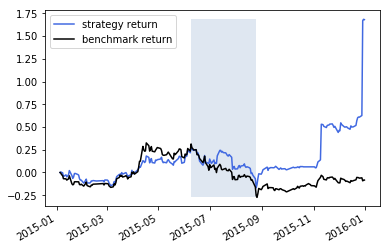

In [22]:
# plot the results
account.ret['rev'].plot(color='royalblue', label='strategy return')
account.ret['benchmark'].plot(color='black', label='benchmark return')
x = np.array(list(account.ret.index))
plt.fill_between(x, max(max(account.ret.rev), max(account.ret.benchmark)),
                     min(min(account.ret.rev), min(account.ret.benchmark)),
                     where=((x <= account.drawdown_end) &
                            (x >= account.drawdown_start)),
                     facecolor='lightsteelblue',
                     alpha=0.4)
plt.legend()
plt.show()
